# Respiratory Diseases Weekly Cases in Mexico during 2020: a covid-19 untested cases analysis

### With data from the ministry of health, we analyze 2020 reported cases of some respiratory diseases to see if covid-19 official figures are being underestimated due to misreporting untested cases under other categories.

- We perform a bootstrapping estimation of the mean for the period 2013-2019 under the assumption that the true underlying distribution is unknown.

Note: Plot text is in Spanish.

In [0]:
#!pip install bayesian_bootstrap

In [0]:
import matplotlib
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
#from bayesian_bootstrap.bootstrap import mean, highest_density_interval

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Population estimates for Mexico 2014-2020 (source: CONAPO)

In [0]:
pob14=119216240.0
pob13=117688241.0
pob15=120653293.0
pob16=122038924.0
pob17=123388002.0
pob18=124692044.0
pob19=125960168.0
pob20=127191826.0
pob=[pob13,pob14,pob15,pob16,pob17,pob18,pob19,pob20]

In [0]:
def boostrap_mean(sample, sample_size, n_iterations):
	bootstrap_samples=np.random.choice(sample, size=(n_iterations,sample_size), replace=True)
	mean_array=np.mean(bootstrap_samples, axis=1)
	data_mean=np.mean(mean_array)
	lower=np.percentile(mean_array,2.5)
	upper=np.percentile(mean_array,97.5)
	return data_mean, lower, upper

In [0]:
def boostrap_std(sample, sample_size, n_iterations):
	bootstrap_samples=np.random.choice(sample, size=(n_iterations,sample_size), replace=True)
	std_array=np.std(bootstrap_samples, axis=1)
	data_std=np.mean(std_array)
	return data_std

In [0]:
def boostrap_median(sample, sample_size, n_iterations):
	bootstrap_samples=np.random.choice(sample, size=(n_iterations,sample_size), replace=True)
	median_array=np.median(bootstrap_samples, axis=1)
	data_median=np.mean(median_array)
	lower=np.percentile(median_array,2.5)
	upper=np.percentile(median_array,97.5)
	return data_median, lower, upper

In [0]:
def boostrap_interquartile(sample, sample_size, n_iterations):
  bootstrap_samples=np.random.choice(sample, size=(n_iterations,sample_size), replace=True)
  p25,p75=np.percentile(bootstrap_samples,[2.5,97.5],axis=1)
  p25_mean=np.mean(p25)
  p75_mean=np.mean(p75)
  lower_25=np.percentile(p25,5)
  upper_25=np.percentile(p25,95)
  lower_75=np.percentile(p75,5)
  upper_75=np.percentile(p75,95)
  return p25_mean, p75_mean

## 1. Pneumonia weekly cases

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/maybje/covid_19/master/datos/neumonia.csv')
df=df.iloc[:,1:]
datos=df.values.astype(float)
for r in range(datos.shape[1]):
  datos[:,r]=(datos[:,r]/pob[r])*1000000


Bootstrapping

In [0]:
d1=datos[:,:-1]
d2=datos[:,-1]
boots=[]
np.random.seed(21)
s=1
semanas=1
for r in d1:
  boot=boostrap_mean(r, r.shape[0],10000)
  boots.append([boot[0], "mean",s])
  boots.append([boot[1], "lower",s])
  boots.append([boot[2], "upper",s])
  s+=1

In [0]:
boots_p=[]
np.random.seed(21)
i=14
for r in range(semanas):
  boot=boostrap_interquartile(d1[i-r,:], d1[i-r,:].shape[0],10000)
  boots_p.append([boot[0], "p_25",d1.shape[0]-semanas+1+r])
  boots_p.append([boot[1], "p_975",d1.shape[0]-semanas+1+r])

Bayesian bootstraping

In [0]:
#boots=[]
#np.random.seed(21)
#s=1
#for r in d1:
#  boot = mean(r, 10000)
#  boot_mean=sum(boot)/len(boot)
#  l, r = highest_density_interval(boot)
#  boots.append([boot_mean, "mean",s])
#  boots.append([l, "lower",s])
#  boots.append([r, "upper",s])
#  s+=1

In [0]:
df_boot = pd.DataFrame(boots, columns=['Boostrap Iterations', 'Mean', "Value"])
df_p=pd.DataFrame(boots_p, columns=['Boostrap Iterations', 'percentile', "Value"])
mean_f=df_boot[df_boot.Mean=="mean"].copy().reset_index(drop=True)
#l_f=df_boot[df_boot.Mean=="lower"].copy().reset_index(drop=True)
#u_f=df_boot[df_boot.Mean=="upper"].copy().reset_index(drop=True)
l_f=df_p[df_p.percentile=="p_25"].iloc[:,0].reset_index(drop=True)/df_boot[df_boot.Mean=="mean"].iloc[-semanas:,0].reset_index(drop=True)
u_f=df_p[df_p.percentile=="p_975"].iloc[:,0].reset_index(drop=True)/df_boot[df_boot.Mean=="mean"].iloc[-semanas:,0].reset_index(drop=True)
delta=mean_f.iloc[:,0].pct_change()

f_2020=[d2[-semanas-1:-semanas][0]]
for i in range(semanas):
  f_2020.append(f_2020[i]*(1+delta.iloc[i-semanas]))

print(np.sum((d2[-semanas:]-f_2020[-semanas:])*pob[-semanas:]/1000000))

-479.4966079511019


In [0]:
f=[[f_2020[-semanas-1],"mean", d1.shape[0]-semanas],[f_2020[-semanas-1],"p_25", d1.shape[0]-semanas],[f_2020[-semanas-1],"p_97", d1.shape[0]-semanas]]
for s in range(semanas):
  f.append([f_2020[-semanas+s],"mean", d1.shape[0]-semanas+s+1])
  f.append([f_2020[-semanas+s]*l_f[s],"p_25", d1.shape[0]-semanas+1+s])
  f.append([f_2020[-semanas+s]*u_f[s],"p_975", d1.shape[0]-semanas+1+s])

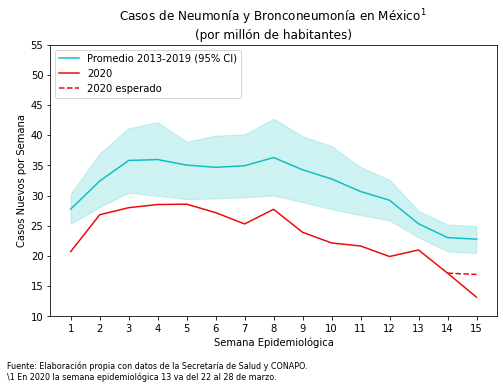

In [0]:
#f = pd.DataFrame(f, columns=['forecast', 'range', "week"])
fig = plt.subplots(1, 1,figsize=(8, 5))
plot=sns.lineplot(df_boot.columns[2], df_boot.columns[0], data=df_boot, color="#0EBFC0", label="Promedio 2013-2019 (95% CI)")
x=list(range(1,len(d2)+1)) #X axis is defined
x2=list(range(len(d2)-semanas,len(d2)+1))
sns.lineplot(x,d2,color="#EC0909", label="2020")
sns.lineplot(x2,f_2020,color="#EC0909", label="2020 esperado")
#sns.lineplot(f.columns[2],f.columns[0],data=f,color="#EC0909", label="2020 esperado")
plot.lines[2].set_linestyle("--")
plot.set(xlabel='Semana Epidemiológica', ylabel='Casos Nuevos por Semana') #labeling axis
plot.legend(loc="upper left") #adding legend
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plot.set_ylim((10,55))
plt.title("Casos de Neumonía y Bronconeumonía en México$^1$ \n(por millón de habitantes)")

plt.figtext(0.05,0.00, "Fuente: Elaboración propia con datos de la Secretaría de Salud y CONAPO. \
\n\\1 En 2020 la semana epidemiológica 13 va del 22 al 28 de marzo.", fontsize=8, va="top", ha="left")
plt.savefig("bootstrap_pob.png", bbox_inches='tight') #saving figure

Interquartile range

In [0]:
boots_25=[]
boots_75=[]
np.random.seed(21)
s=1
for r in d1:
  boot=boostrap_interquartile(r, r.shape[0],10000)
  boots_25.append([boot[0], "mean_25",s])
  s+=1

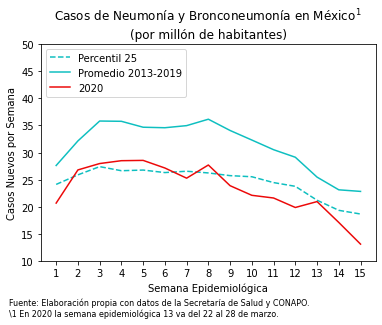

In [0]:
df_boot25 = pd.DataFrame(boots_25, columns=['Boostrap Iterations', 'P25', "Value"])
plot=sns.lineplot(df_boot25.columns[2], df_boot25.columns[0], data=df_boot25, color="#0EBFC0", label="Percentil 25")
sns.lineplot(df_boot.columns[2], df_boot.columns[0], data=df_boot[df_boot["Mean"]=="mean"], color="#0EBFC0", label="Promedio 2013-2019")
plot.lines[0].set_linestyle("--")
x=list(range(1,len(d2)+1)) #X axis is defined
sns.lineplot(x,d2,color="#EC0909", label="2020")
plot.set(xlabel='Semana Epidemiológica', ylabel='Casos Nuevos por Semana') #labeling axis
plot.legend(loc="upper left") #adding legend
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plot.set_ylim((10,50))
plt.title("Casos de Neumonía y Bronconeumonía en México$^1$ \n(por millón de habitantes)")

plt.figtext(0.05,0.00, "Fuente: Elaboración propia con datos de la Secretaría de Salud y CONAPO. \
\n\\1 En 2020 la semana epidemiológica 13 va del 22 al 28 de marzo.", fontsize=8, va="top", ha="left")
plt.savefig("bootstrap_pob.png", bbox_inches='tight') #saving figure

## 2. Acute Respiratory Infection weekly cases

In [0]:
df2 = pd.read_csv('https://raw.githubusercontent.com/maybje/covid_19/master/datos/infeccion_respiratoria_aguda.csv')
df2=df2.iloc[:,1:]
datos2=df2.values
for r in range(datos2.shape[1]):
  datos2[:,r]=(datos2[:,r]/pob[r])*1000000

In [0]:
d12=datos2[:,:-1]
d22=datos2[:,-1]
boots2=[]
np.random.seed(21)
s=1
semanas=3
for r in d12:
  boot2=boostrap_mean(r, r.shape[0],10000)
  boots2.append([boot2[0], "mean",s])
  boots2.append([boot2[1], "lower",s])
  boots2.append([boot2[2], "upper",s])
  s+=1

In [0]:
boots_p2=[]
np.random.seed(21)
i=14
for r in range(semanas):
  boot=boostrap_interquartile(d12[i-r,:], d12[i-r,:].shape[0],10000)
  boots_p2.append([boot[0], "p_25",d12.shape[0]-semanas+1+r])
  boots_p2.append([boot[1], "p_975",d12.shape[0]-semanas+1+r])

In [0]:
df_boot2 = pd.DataFrame(boots2, columns=['Boostrap Iterations', 'Mean', "Value"])
df_p2=pd.DataFrame(boots_p2, columns=['Boostrap Iterations', 'percentile', "Value"])
mean_f2=df_boot2[df_boot2.Mean=="mean"].copy().reset_index(drop=True)
#l_f=df_boot[df_boot.Mean=="lower"].copy().reset_index(drop=True)
#u_f=df_boot[df_boot.Mean=="upper"].copy().reset_index(drop=True)
l_f=df_p2[df_p2.percentile=="p_25"].iloc[:,0].reset_index(drop=True)/df_boot2[df_boot2.Mean=="mean"].iloc[-semanas:,0].reset_index(drop=True)
u_f=df_p2[df_p2.percentile=="p_975"].iloc[:,0].reset_index(drop=True)/df_boot2[df_boot2.Mean=="mean"].iloc[-semanas:,0].reset_index(drop=True)
delta=mean_f2.iloc[:,0].pct_change()

f_2020=[d22[-semanas-1:-semanas][0]]
for i in range(semanas):
  f_2020.append(f_2020[i]*(1+delta.iloc[i-semanas]))

print(np.sum((d22[-semanas:]-f_2020[-semanas:])*pob[-semanas:]/1000000))
print(np.sum((d22[-1]-f_2020[-1])*pob[-1]/1000000))

119040.00850610362
-154859.43400542103


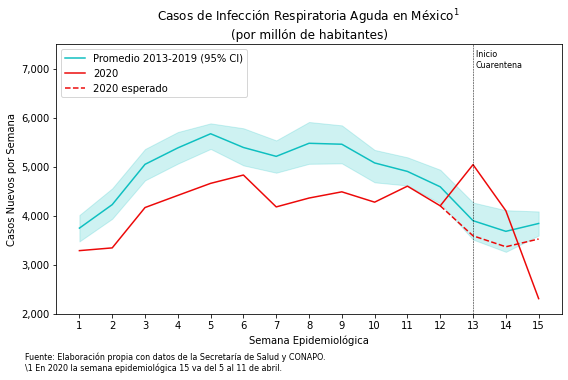

In [0]:
fig = plt.subplots(1, 1,figsize=(8, 5))
df_boot2 = pd.DataFrame(boots2, columns=['Boostrap Iterations', 'Mean', "Value"])
plot2=sns.lineplot(df_boot2.columns[2], df_boot2.columns[0], data=df_boot2, color="#0EBFC0", label="Promedio 2013-2019 (95% CI)")
x2=list(range(1,len(d22)+1)) #X axis is defined
x22=list(range(len(d22)-semanas,len(d22)+1))
sns.lineplot(x2,d22,color="#EC0909", label="2020")
sns.lineplot(x22,f_2020,color="#EC0909", label="2020 esperado")
plt.axvline(13, ls="--", color="black", linewidth=0.5)
plot2.text(0.83, 0.98, "Inicio \nCuarentena", size=8, color="black", ha="left", va="top", transform=plot2.transAxes)
plot2.lines[2].set_linestyle("--")
plot2.set(xlabel='Semana Epidemiológica', ylabel='Casos Nuevos por Semana') #labeling axis
plot2.legend(loc="upper left") #adding legend
plt.xticks(np.arange(min(x2), max(x2)+1, 1.0))
plot2.set_ylim((2000,7500))
plot2.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda y, p: format(int(y), ',')))
plt.title("Casos de Infección Respiratoria Aguda en México$^1$ \n(por millón de habitantes)")
plt.figtext(0.05,0.01, "Fuente: Elaboración propia con datos de la Secretaría de Salud y CONAPO.\
\n\\1 En 2020 la semana epidemiológica 15 va del 5 al 11 de abril.", fontsize=8, va="top", ha="left")
plt.tight_layout()
plt.savefig("ira.png", bbox_inches='tight') #saving figure

In [0]:
boots_225=[]
boots_275=[]
np.random.seed(21)
s=1
for r in d12:
  boot=boostrap_interquartile(r, r.shape[0],10000)
  boots_225.append([boot[0], "mean_25",s])
  boots_225.append([boot[1], "lower_25",s])
  boots_225.append([boot[2], "upper_25",s])
  boots_275.append([boot[3], "mean_25",s])
  boots_275.append([boot[4], "lower_25",s])
  boots_275.append([boot[5], "upper_25",s])
  s+=1

In [0]:
#np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

## 3. Influenza weekly cases

In [0]:
df3 = pd.read_csv('https://raw.githubusercontent.com/maybje/covid_19/master/datos/influenza.csv')

df3=df3.iloc[:,1:]

datos3=df3.values.astype(float)
for r in range(datos3.shape[1]):
  datos3[:,r]=np.true_divide(datos3[:,r],pob[r])*1000000

In [0]:
d13=datos3[:,:-1]
d23=datos3[:,-1]
boots3=[]
np.random.seed(21)
s=1
for r in d13:
  boot3=boostrap_mean(r, r.shape[0],10000)
  boots3.append([boot3[0], "mean",s])
  boots3.append([boot3[1], "lower",s])
  boots3.append([boot3[2], "upper",s])
  s+=1

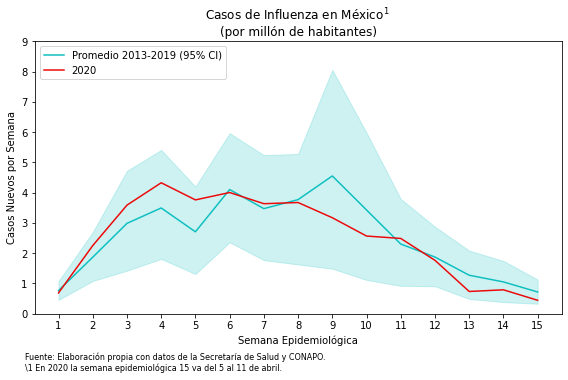

In [0]:
fig = plt.subplots(1, 1,figsize=(8, 5))
df_boot3 = pd.DataFrame(boots3, columns=['Boostrap Iterations', 'Mean', "Value"])
plot3=sns.lineplot(df_boot3.columns[2], df_boot3.columns[0], data=df_boot3,\
                   color="#0EBFC0", label="Promedio 2013-2019 (95% CI)")
x3=list(range(1,len(d23)+1)) #X axis is defined
sns.lineplot(x3,d23,color="#EC0909", label="2020")
plot3.set(xlabel='Semana Epidemiológica', ylabel='Casos Nuevos por Semana') #labeling axis
plot3.legend(loc="upper left") #adding legend
plt.xticks(np.arange(min(x3), max(x3)+1, 1.0))
plot3.set_ylim((0,9))
plt.title("Casos de Influenza en México$^1$ \n(por millón de habitantes)")
plt.figtext(0.05,0.01, "Fuente: Elaboración propia con datos de la Secretaría de Salud y CONAPO.\
\n\\1 En 2020 la semana epidemiológica 15 va del 5 al 11 de abril.", fontsize=8, va="top", ha="left")
plt.tight_layout()
plt.savefig("influenza.png", bbox_inches='tight') #saving figure